<a href="https://colab.research.google.com/github/nibaskumar93n-debug/Morphoinformatics/blob/main/Stamp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

!pip install pandas scipy statsmodels matplotlib seaborn pingouin
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 8.9 MB/s eta 0:00:00


In [3]:
# Load pathway table
path_abun = pd.read_csv("/content/path_abun_unstrat_CRC_sig.tsv", sep="\t", comment="#")
path_abun = path_abun.set_index("pathway").T
path_abun.index.name = "Sample"
path_abun.reset_index(inplace=True)

print("Pathway abundance shape:", path_abun.shape)




Pathway abundance shape: (148, 259)


In [4]:

# Load metadata
metadata = pd.read_csv("/content/metadata7.tsv", sep="\t")

# Merge on 'Sample'
merged = pd.merge(metadata, path_abun, on="Sample", how="inner")
print("Merged shape:", merged.shape)


Merged shape: (74, 263)


In [5]:
# Ensure numeric data for pathways
for col in merged.columns:
    if col not in ["Sample", "h_c"]:
        merged[col] = pd.to_numeric(merged[col], errors="coerce")

# Check groups
print("Groups in h_c:", merged["h_c"].unique())
groups = merged["h_c"].unique()
if len(groups) != 2:
    raise ValueError(f"Expected 2 groups for t-test, found {len(groups)}")

group1, group2 = groups[0], groups[1]
print(f"Group 1: {group1}, Group 2: {group2}")


Groups in h_c: ['S_C' 'S_N']
Group 1: S_C, Group 2: S_N


In [6]:
# Perform t-tests
results = []
for pathway in [c for c in merged.columns if c not in ["Sample", "h_c"]]:
    g1 = merged[merged["h_c"] == group1][pathway].dropna()
    g2 = merged[merged["h_c"] == group2][pathway].dropna()

    if len(g1) > 1 and len(g2) > 1:
        t_stat, p_val = stats.ttest_ind(g1, g2, equal_var=False)
        mean_diff = g2.mean() - g1.mean()
        cohen_d = pg.compute_effsize(g1, g2, eftype="cohen")
        results.append([pathway, mean_diff, p_val, cohen_d])

df_res = pd.DataFrame(results, columns=["pathway", "Mean_Diff", "P_value", "Cohen_d"])


In [7]:
# Apply FDR correction (Benjamini-Hochberg)
rejected, fdr_corrected, _, _ = multipletests(
    df_res["P_value"],
    alpha=0.05,
    method='fdr_bh'
)
df_res["FDR"] = fdr_corrected
df_res["Significant"] = rejected

print(f"\nTotal pathways tested: {len(df_res)}")
print(f"Significant pathways (FDR < 0.05): {df_res['Significant'].sum()}")

# Save all results
df_res.to_csv("/content/STAMP_like_results.csv", index=False)
print("\nAll results saved to /content/STAMP_like_results.csv")

# Filter for significant pathways only
sig_res = df_res[df_res["Significant"] == True].copy()
sig_res = sig_res.sort_values("FDR")

# Save significant pathways
sig_res.to_csv("/content/STAMP_significant_pathways.csv", index=False)
print(f"Saved {len(sig_res)} significant pathways to /content/STAMP_significant_pathways.csv")


Total pathways tested: 258
Significant pathways (FDR < 0.05): 25

All results saved to /content/STAMP_like_results.csv
Saved 25 significant pathways to /content/STAMP_significant_pathways.csv


In [9]:
# Add pathway names from MetaCyc mapping file
pwy_names = pd.read_csv("/content/metacyc-pwy_name.tsv", sep="\t", engine='python')
pwy_names.columns = pwy_names.columns.str.strip()
sig_res.columns = sig_res.columns.str.strip()

# Merge with significant results
sig_res_named = pd.merge(sig_res, pwy_names, on="pathway", how="left")
sig_res_named["Pathway_Name"] = sig_res_named["name"].fillna(sig_res_named["pathway"])
sig_res_named.to_csv("/content/STAMP_significant_pathways_named.csv", index=False)
print("Named significant pathways saved to /content/STAMP_significant_pathways_named.csv")


Named significant pathways saved to /content/STAMP_significant_pathways_named.csv


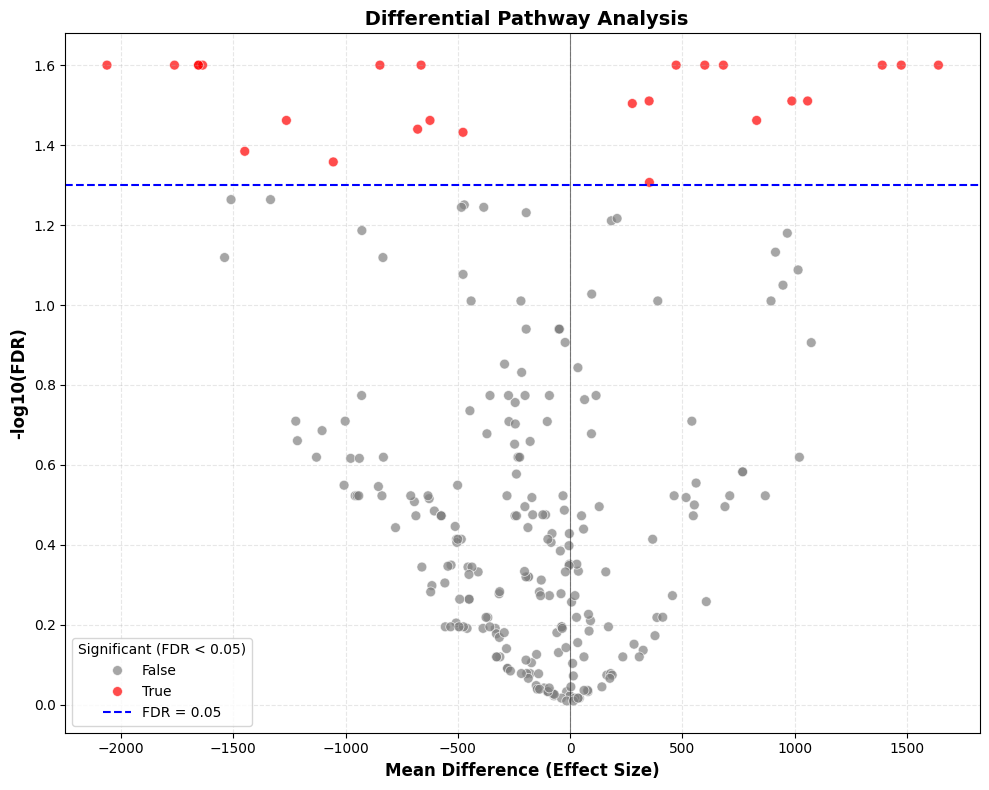


✓ Volcano plot saved to /content/STAMP_volcano_plot.png


In [10]:
# ========== CREATE VOLCANO PLOT ==========

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_res,
    x="Mean_Diff",
    y=-np.log10(df_res["FDR"]),
    hue="Significant",
    palette={True: "red", False: "grey"},
    s=50,
    alpha=0.7
)

plt.xlabel("Mean Difference (Effect Size)", fontsize=12, fontweight='bold')
plt.ylabel("-log10(FDR)", fontsize=12, fontweight='bold')
plt.title(" Differential Pathway Analysis", fontsize=14, fontweight='bold')
plt.axhline(-np.log10(0.05), color="blue", ls="--", linewidth=1.5, label="FDR = 0.05")
plt.axvline(0, color="black", ls="-", linewidth=0.8, alpha=0.5)
plt.legend(title="Significant (FDR < 0.05)", fontsize=10)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()

# Save the volcano plot
plt.savefig("/content/STAMP_volcano_plot.png", dpi=600, bbox_inches="tight")
plt.show()
print("\n✓ Volcano plot saved to /content/STAMP_volcano_plot.png")




Creating plot with top 25 pathways...


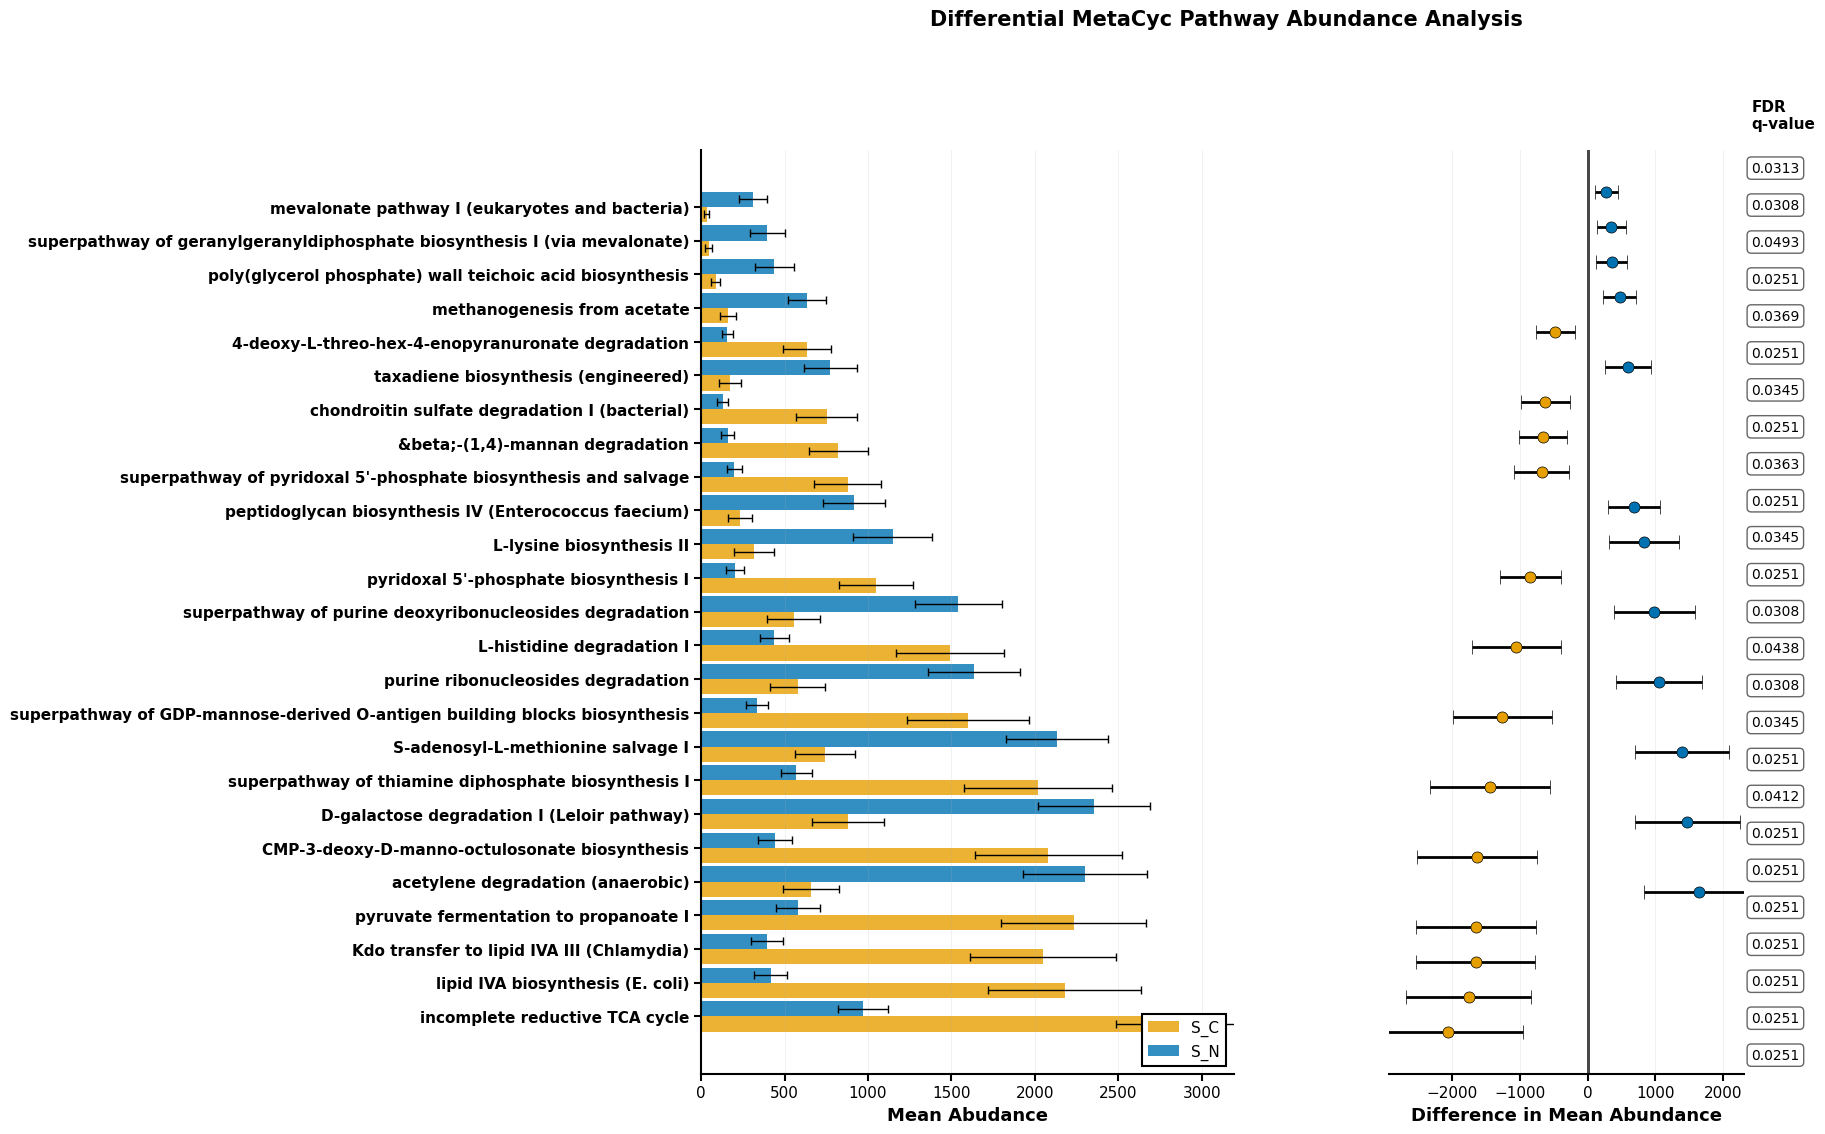


✓ Two-panel STAMP-style plot saved:
  - PNG: /content/STAMP_style_two_panel.png (300 DPI)
  - PDF: /content/STAMP_style_two_panel.pdf (vector format)
✓ Plotted 25 significant pathways
✓ Group 1 (S_C): Blue bars
✓ Group 2 (S_N): Magenta bars


In [11]:
# Select top N pathways (adjust as needed)
top_n = 25
top_sig = sig_res_named.head(top_n)

print(f"\nCreating plot with top {len(top_sig)} pathways...")

# Prepare data for plotting
plot_data = []
for pathway in top_sig["pathway"].tolist():
    g1_data = merged[merged["h_c"] == group1][pathway].dropna()
    g2_data = merged[merged["h_c"] == group2][pathway].dropna()

    # Keep original scale - do NOT multiply
    g1_mean = g1_data.mean()
    g2_mean = g2_data.mean()
    g1_sem = g1_data.sem()
    g2_sem = g2_data.sem()

    diff = g2_mean - g1_mean

    # Get pathway name and FDR
    pathway_name = top_sig[top_sig["pathway"] == pathway]["Pathway_Name"].values[0]
    fdr_value = top_sig[top_sig["pathway"] == pathway]["FDR"].values[0]

    plot_data.append({
        "Pathway": pathway_name,
        f"{group1}_mean": g1_mean,
        f"{group2}_mean": g2_mean,
        f"{group1}_sem": g1_sem,
        f"{group2}_sem": g2_sem,
        "Difference": diff,
        "FDR": fdr_value
    })

plot_df = pd.DataFrame(plot_data)

# Sort by absolute difference (or FDR)
plot_df = plot_df.sort_values("Difference", key=abs, ascending=False)

# Create figure with two subplots - adjusted size for publication
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 12),
                                gridspec_kw={'width_ratios': [1.8, 1.2], 'wspace': 0.35})

# Color scheme - matching your reference plot
color1 = '#E69F00'  # Blue for S_C (group 1)["", ""]
color2 = '#0072B2'  # Orange for S_N (group 2)

y_positions = np.arange(len(plot_df))
bar_height = 0.45 # Thicker bars (was 0.35)

# LEFT PANEL: Mean proportions with error bars (side by side bars)
for i, row in plot_df.iterrows():
    idx = list(plot_df.index).index(i)

    # Plot group 1 bar (blue)
    ax1.barh(idx - bar_height/2, row[f"{group1}_mean"], height=bar_height,
             color=color1, align='center', alpha=0.8, label=group1 if idx == 0 else "")
    ax1.errorbar(row[f"{group1}_mean"], idx - bar_height/2,
                 xerr=row[f"{group1}_sem"], fmt='none',
                 ecolor='black', capsize=3, linewidth=1)

    # Plot group 2 bar (orange)
    ax1.barh(idx + bar_height/2, row[f"{group2}_mean"], height=bar_height,
             color=color2, align='center', alpha=0.8, label=group2 if idx == 0 else "")
    ax1.errorbar(row[f"{group2}_mean"], idx + bar_height/2,
                 xerr=row[f"{group2}_sem"], fmt='none',
                 ecolor='black', capsize=3, linewidth=1)

ax1.set_yticks(y_positions)
ax1.set_yticklabels(plot_df["Pathway"], fontsize=11, weight='bold')  # Professional font
ax1.set_xlabel("Mean Abudance", fontsize=13, fontweight='bold', family='sans-serif')
ax1.set_xlim(0, ax1.get_xlim()[1] * 0.85)  # Reduce bar length by 15%
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_linewidth(1.5)
ax1.spines['bottom'].set_linewidth(1.5)
ax1.tick_params(axis='both', which='major', labelsize=11, width=1.5, length=5)
ax1.grid(axis='x', alpha=0.25, linestyle='-', linewidth=0.5)

# Add legend with better styling
legend = ax1.legend(loc='lower right', fontsize=11, frameon=True,
                   fancybox=False, edgecolor='black', framealpha=1)
legend.get_frame().set_linewidth(1.5)

# Remove alternating background for cleaner publication look
# for i in range(0, len(plot_df), 2):
#     ax1.axhspan(i - 0.5, i + 0.5, facecolor='gray', alpha=0.1, zorder=0)

# RIGHT PANEL: Difference in mean proportions with confidence intervals
for i, row in plot_df.iterrows():
    idx = list(plot_df.index).index(i)
    diff = row["Difference"]

    # Calculate combined SEM for difference
    combined_sem = np.sqrt(row[f"{group1}_sem"]**2 + row[f"{group2}_sem"]**2)
    ci_95 = 1.96 * combined_sem  # 95% confidence interval

    # Color based on direction (all are significant since FDR < 0.05)
    # Orange for increased in group2, Blue for increased in group1
    point_color = color2 if diff > 0 else color1

    # Plot point and error bar with publication-quality styling
    ax2.errorbar(diff, idx, xerr=ci_95, fmt='o',
                 color=point_color, ecolor='black',
                 capsize=5, markersize=8, linewidth=2,
                 markeredgecolor='black', markeredgewidth=0.5)

# Add vertical line at zero with better styling
ax2.axvline(0, color='black', linestyle='-', linewidth=2, alpha=0.8, zorder=0)

ax2.set_yticks(y_positions)
ax2.set_yticklabels([])  # Remove y-axis labels (shared with left panel)
ax2.set_xlabel("Difference in Mean Abundance", fontsize=13, fontweight='bold', family='sans-serif')
# Adjust x-axis limits to reduce bar length
current_xlim = ax2.get_xlim()
x_range = current_xlim[1] - current_xlim[0]
ax2.set_xlim(current_xlim[0] * 0.85, current_xlim[1] * 0.85)  # Reduce range by 15%
ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_linewidth(1.5)
ax2.tick_params(axis='x', which='major', labelsize=11, width=1.5, length=5)
ax2.tick_params(left=False)
ax2.grid(axis='x', alpha=0.25, linestyle='-', linewidth=0.5)

# Remove alternating background for publication quality
# for i in range(0, len(plot_df), 2):
#     ax2.axhspan(i - 0.5, i + 0.5, facecolor='gray', alpha=0.1, zorder=0)

# Add p-value labels OUTSIDE the axes on the right
for i, row in plot_df.iterrows():
    idx = list(plot_df.index).index(i)
    fdr_val = row["FDR"]

    # Format FDR value
    if fdr_val < 1e-10:
        p_text = f"<1e-10"
    elif fdr_val < 0.0001:
        p_text = f"<{fdr_val:.0e}"
    elif fdr_val < 0.001:
        p_text = f"{fdr_val:.2e}"
    else:
        p_text = f"{fdr_val:.4f}"

    # Convert axis coordinates to figure coordinates for placement outside
    # Position at x=1.02 (just outside the right edge of ax2)
    ax2.text(1.02, (idx + 0.5) / len(plot_df), p_text,
             transform=ax2.transAxes,
             va='center', ha='left', fontsize=10,
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                      edgecolor='#666666', alpha=1, linewidth=1))

# Add "p-value (corrected)" label at the top, outside axes
ax2.text(1.02, 1.02, "FDR\nq-value",
         transform=ax2.transAxes,
         va='bottom', ha='left', fontsize=11, fontweight='bold', family='sans-serif')

plt.suptitle("Differential MetaCyc Pathway Abundance Analysis",
             fontsize=15, fontweight='bold', y=0.997, family='sans-serif')

# Adjust layout to accommodate external p-values
plt.subplots_adjust(right=0.87)  # Make room on the right for p-values

# Use tight_bbox to ensure nothing is cut off
plt.savefig("/content/STAMP_style_two_panel.png", dpi=300, bbox_inches="tight",
            facecolor='white', edgecolor='none')
plt.savefig("/content/STAMP_style_two_panel.pdf", bbox_inches="tight",
            facecolor='white', edgecolor='none')  # Also save as PDF for publications
plt.show()

print("\n✓ Two-panel STAMP-style plot saved:")
print("  - PNG: /content/STAMP_style_two_panel.png (300 DPI)")
print("  - PDF: /content/STAMP_style_two_panel.pdf (vector format)")
print(f"✓ Plotted {len(plot_df)} significant pathways")
print(f"✓ Group 1 ({group1}): Blue bars")
print(f"✓ Group 2 ({group2}): Magenta bars")

Named significant pathways saved.


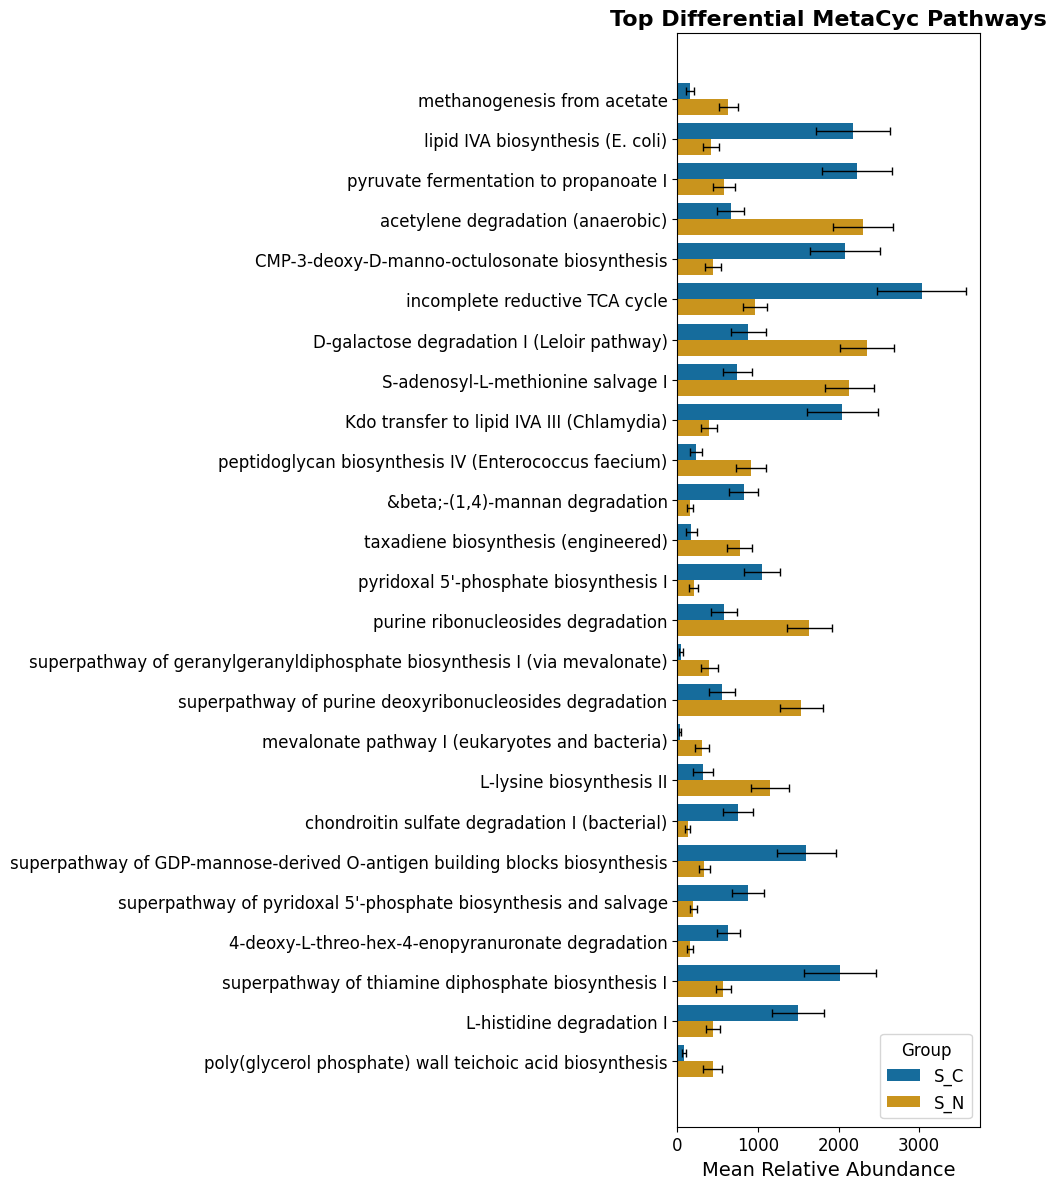

Publication-ready STAMP-style bar plot saved to /content/STAMP_like_barplot_publication.png


In [58]:
# 🧩 Step 7: Add pathway names (from MetaCyc mapping file)
pwy_names = pd.read_csv("/content/metacyc-pwy_name.tsv", sep="\t", engine='python')
pwy_names.columns = pwy_names.columns.str.strip()
sig_res.columns = sig_res.columns.str.strip()

# Rename for consistency
sig_res = sig_res.rename(columns={'Pathway': 'pathway'})
pwy_names = pwy_names.rename(columns={'name': 'Pathway_Name'})

# Merge with significant results
sig_res_named = pd.merge(sig_res, pwy_names, on="pathway", how="left")
sig_res_named["Pathway_Name"] = sig_res_named["Pathway_Name"].fillna(sig_res_named["pathway"])
sig_res_named.to_csv("/content/STAMP_significant_pathways_named.csv", index=False)
print("Named significant pathways saved.")

# 🧮 Step 8: Prepare data for plotting
top_n = 25  # number of top pathways to plot
top_sig = sig_res_named.head(top_n)

# Melt data
df_melt = merged.melt(
    id_vars=["Sample", "h_c"],
    value_vars=top_sig["pathway"].tolist(),
    var_name="pathway",
    value_name="Abundance"
)

# Add readable pathway names
df_melt = pd.merge(df_melt, pwy_names, on="pathway", how="left")
df_melt["Pathway_Name"] = df_melt["Pathway_Name"].fillna(df_melt["pathway"])

# Compute group summary (mean ± SEM)
summary = df_melt.groupby(["Pathway_Name", "h_c"])["Abundance"].agg(["mean", "sem"]).reset_index()

# Keep original order from top_sig
pathway_order = top_sig["Pathway_Name"].tolist()
summary["Pathway_Name"] = pd.Categorical(summary["Pathway_Name"], categories=pathway_order, ordered=True)

# 🎨 Step 9: Publication-ready STAMP-style bar plot
plt.figure(figsize=(10, 12))
colors = ["#0072B2", "#E69F00"]  # Blue=Healthy, Orange=CRC

sns.barplot(
    data=summary,
    y="Pathway_Name",
    x="mean",
    hue="h_c",
    palette=colors,
    errorbar=None,  # updated for Seaborn v0.12+
    orient="h"
)

# Add error bars correctly
for i, row in summary.iterrows():
    y_pos = list(pathway_order).index(row["Pathway_Name"])
    x_val = row["mean"]
    x_err = row["sem"]
    hue_offset = -0.2 if row["h_c"] == summary["h_c"].unique()[0] else 0.2
    plt.errorbar(
        x=x_val,
        y=y_pos + hue_offset,
        xerr=x_err,
        fmt="none",
        ecolor="black",
        capsize=3,
        lw=1
    )

# Clean labels and fonts
plt.title("Top Differential MetaCyc Pathways", fontsize=16, weight='bold')
plt.xlabel("Mean Relative Abundance", fontsize=14)
plt.ylabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Group", fontsize=12, title_fontsize=12, loc="lower right")
plt.tight_layout()

# Save figure in high resolution
plt.savefig("/content/STAMP_like_barplot_publication.png", dpi=600, bbox_inches="tight")
plt.show()

print("Publication-ready STAMP-style bar plot saved to /content/STAMP_like_barplot_publication.png")



